# Section 7 Compliance Exploration
## Preliminary analysis

This is a preliminary analysis of the data that Tiffany Kim has collected for evaluating how often remotely sensed imagery can be used to check for compliance with section 7 of the US Endangered Species Act. 

_(Note: This is also me testing the utility of Jupyter for analyses.)_

In [2]:
metadata = list('image/svg+xml' = list(isolated = TRUE))

In [18]:
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width=10, repr.plot.height=6)

In [2]:
list.files("../data")

[1] "joined_w_Nconsults_Nformal.tab"              
 [2] "joined_w_Nconsults.tab"                      
 [3] "random_sample_formal_consults_w_decdeg.tab"  
 [4] "random_sample_informal_consults_w_decdeg.tab"
 [5] "remote_sensing_eval_informal.xlsx"           
 [6] "remote_sensing_monitor_evaluation.xlsx"      
 [7] "workType_JMalcom.tab"                        
 [8] "workType_TKim_v2.tab"                        
 [9] "workType_TKim.tab"                           
[10] "workTypes_reconcile.tab"

In [4]:
library(dplyr)
library(ggplot2)
library(ggrepel)
library(ggthemes)
library(lubridate)
library(readxl)
library(stringr)

source("./multiplot.R")



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
###############################################################################
# Load the data and prep
base <- "/Users/jacobmalcom/Repos/Defenders/compliance_exploration"
form_eval <- paste0(base, "/data/remote_sensing_monitor_evaluation.xlsx")
inform_eval <- paste0(base, "/data/remote_sensing_eval_informal.xlsx")
form_consults <- paste0(base, "/data/random_sample_formal_consults_w_decdeg.tab")
inform_consults <- paste0(base, "/data/random_sample_informal_consults_w_decdeg.tab")
expected_f <- paste0(base, "/data/joined_w_Nconsults_Nformal.tab")

form <- read_excel(form_eval, sheet = 1)
inform <- read_excel(inform_eval, sheet = 1)
form_cons <- read.table(form_consults, 
                        header = T, 
                        sep = "\t", 
                        stringsAsFactors = F)
inform_cons <- read.table(inform_consults, 
                          header = T, 
                          sep = "\t", 
                          stringsAsFactors = F)
expect <- read.table(expected_f, header = T, sep = "\t", stringsAsFactors = F)



In [6]:
ls()

[1] "base"            "expect"          "expected_f"      "form"           
 [5] "form_cons"       "form_consults"   "form_eval"       "inform"         
 [9] "inform_cons"     "inform_consults" "inform_eval"     "metadata"       
[13] "multiplot"

In [7]:
head(expect)

,Work_type,with_coord,N_consultations,JM_expect,TK_expect,reconcile,N_formal
1,** other **,FALSE,2011,NA,0,NA,188
2,** other **,TRUE,1436,NA,0,NA,62
3,agriculture,FALSE,260,0.5,0.5,0.5,11
4,agriculture,TRUE,397,0.5,0.5,0.5,9
5,agriculture - concentrated animal feeding operation - cattle,FALSE,7,1,1,1,0
6,agriculture - concentrated animal feeding operation - cattle,TRUE,5,1,1,1,1


In [8]:
# Winnow to just the rows with data
form <- form[1:146, ]
inform <- inform[1:50, ]
expect <- expect[expect$with_coord == TRUE, ]

### Joining tables

The data that we need is spread across several different tables imported above. Now we will use `dplyr` to make database table-like joins.

In [9]:
###############################################################################
# Formal consultations
#
# Do the first join to get consult data
form_1 <- left_join(form, form_cons, by = "activity_code")
# dim(form_1)
# names(form_1)
form_1 <- form_1[, c(1:12, 15:20, 23:27, 34:36, 49)]
# names(form_1)

# Do the second join to get our expectations
form_dat <- left_join(form_1, expect, by = c("work_type" = "Work_type"))
names(form_dat)[2] <- "action_found"

In [10]:
# Informal consultations
#
# Do the first join to get consult data
inform_1 <- left_join(inform, inform_cons, by = "activity_code")
# dim(inform_1)
# glimpse(inform_1)
# names(inform_1)
inform_1 <- inform_1[, c(1:12, 15:20, 23:27, 34:36, 49)]
# names(inform_1)

# Do the second join to get our expectations
inform_dat <- left_join(inform_1, expect, by = c("work_type" = "Work_type"))
names(inform_dat)[2] <- "action_found"

In [11]:
# some type conversions for formal and informal
form_dat$area <- as.numeric(form_dat$area)
inform_dat$area <- as.numeric(inform_dat$area)
form_dat$start_date <- mdy(form_dat$start_date)
inform_dat$start_date <- mdy(inform_dat$start_date)
form_dat$FWS_concl_date <- mdy(form_dat$FWS_concl_date)
inform_dat$FWS_concl_date <- mdy(inform_dat$FWS_concl_date)

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercion

_The NAs are fine...they are, in fact, NA_

In [12]:
# make a combined df
names(inform_dat)[9] <- "completed"
form_dat$formal_in <- rep("formal", length(form_dat$activity_code))
inform_dat$formal_in <- rep("informal", length(inform_dat$activity_code))
combo_dat <- rbind(form_dat, inform_dat)

In [13]:
make_expect_obs_hist <- function(dat) {
    par(mfrow=c(1,2))
    hist(dat$reconcile,
         xlab = "No    <--- Expect to see? --->    Yes",
         ylab = "Frequency",
         main = "")
    hist(dat$action_found,
         xlab = "No    <--- Observed? --->    Yes",
         ylab = "",
         main = "")
    par(mfrow=c(1,1))
}

## Plots and such

First, let's compare the distribution of whether we expected to see something to the rate at which we actually saw something. First, the formal consultations:

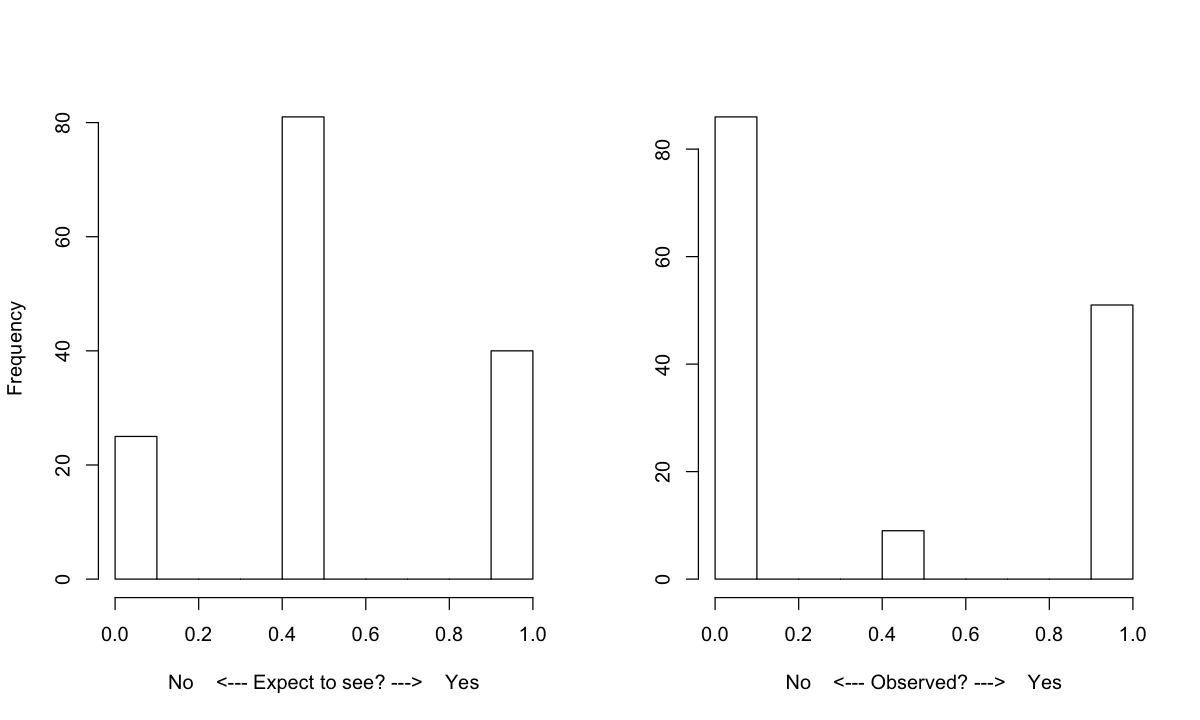

In [19]:
make_expect_obs_hist(form_dat)

On the left we have the "Expected", and our (mine and Tiffany's consensus) suggested there might be a lot of consultations we weren't sure if we would see (0.5). After collecting data on 142 consultations, the vast majority of our uncertainties were not visible (right plot).

_And now_ the informal consultations:

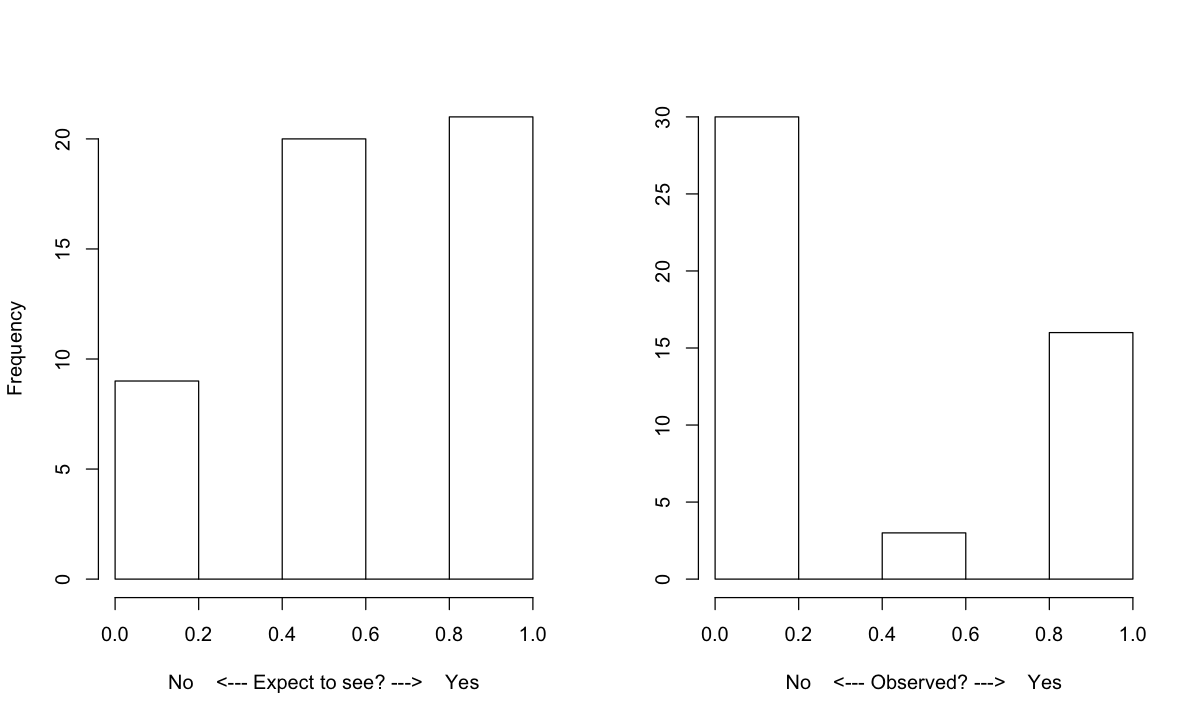

In [20]:
make_expect_obs_hist(inform_dat)

For the 50 informal consultations evaluated so far, we expected more in the "will see" category (1; ~22). But we end up losing a few, and see more unobservable.

----

#### Now let's look by work cat and type

In [16]:
scatter_and_violin_work_cat <- function(dat) {
    plt <- ggplot(dat, aes(factor(work_category), action_found)) +
           geom_violin(fill = "#D1E9D6", colour = "white") +
           geom_jitter(width = 0.3, height = 0.05, alpha = 0.3, size = 4) +
           labs(x = "",
                y = "No              <--- Action found? --->              Yes") +
           theme(axis.text.x = element_text(angle = 40, hjust = 1)) +
           theme_hc()
    plt
}

Warning message:
: Removed 1 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 1 rows containing missing values (geom_point).

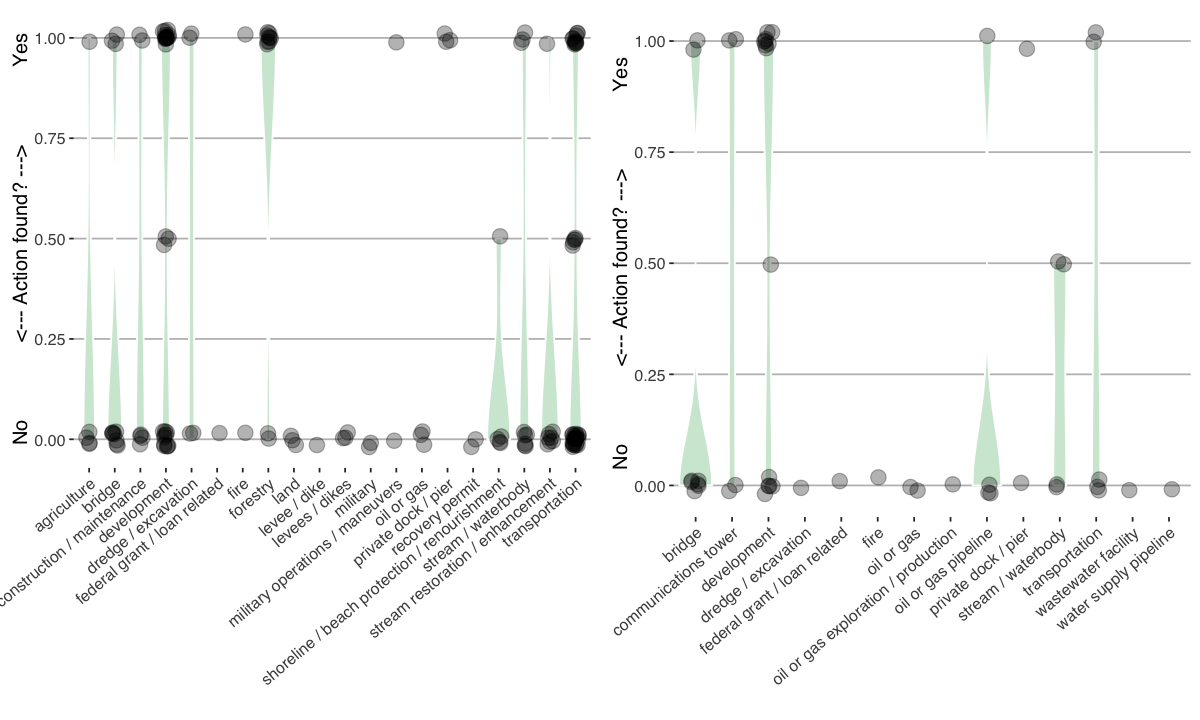

In [21]:
# pdf(file = "test_img.pdf", height = 7, width = 10)
# multiplot(scatter_and_violin_work_cat(form_dat),
#           scatter_and_violin_work_cat(inform_dat),
#           cols = 2)
# dev.off()

multiplot(scatter_and_violin_work_cat(form_dat),
          scatter_and_violin_work_cat(inform_dat),
          cols = 2)

_Why are the R and ggplot plots not filling the width of the page? Is there way to make them wider???_

Yes, maybe. See [this blog post](http://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html)

Warning message:
: Removed 1 rows containing non-finite values (stat_ydensity).Warning message:
: Removed 1 rows containing missing values (geom_point).

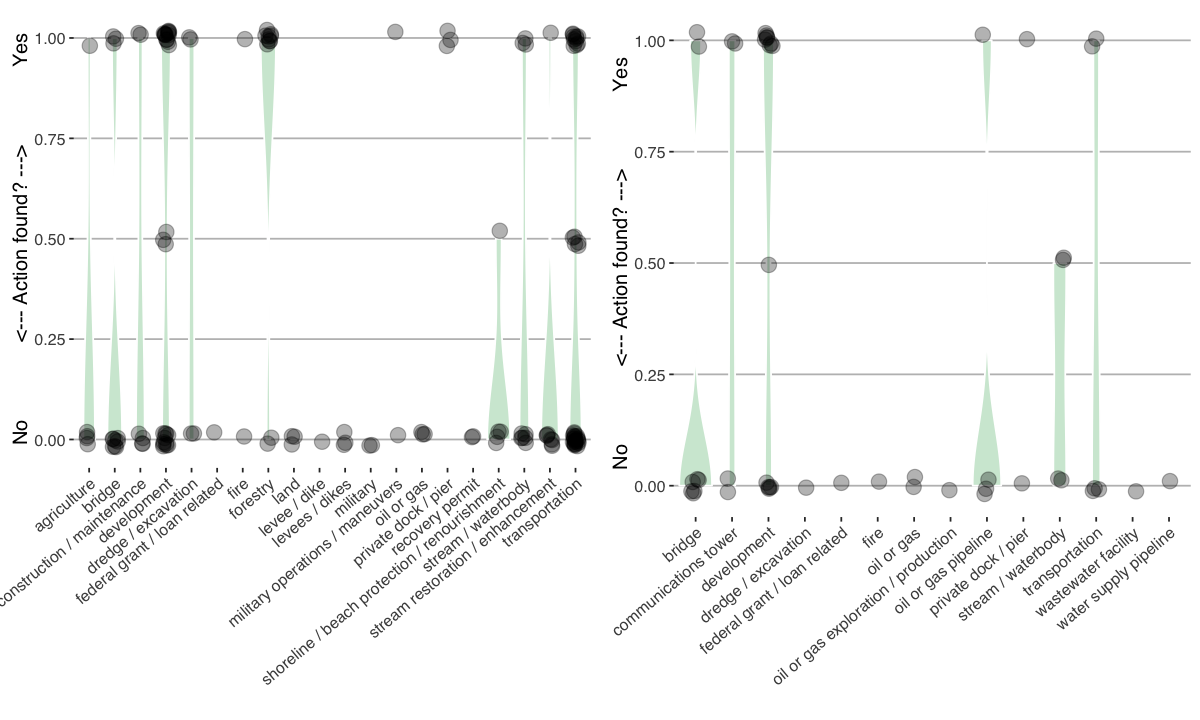

In [22]:
options(repr.plot.width=10, repr.plot.height=6)
metadata = list('image/svg+xml' = list(isolated = TRUE))
multiplot(scatter_and_violin_work_cat(form_dat),
          scatter_and_violin_work_cat(inform_dat),
          cols = 2)

_Hey, that worked!_ :tada:

----

### Sidetrack #1

What is the distribution of earliest images available across the sites evaluated?

In [26]:
mean(form_dat$earliest_date, na.rm = T)
median(form_dat$earliest_date, na.rm = T)
summary(form_dat$earliest_date, na.rm = T)


[1] "1991-08-07 06:34:31 UTC"

[1] "1993-07-16 12:00:00 UTC"

                 Min.               1st Qu.                Median 
"1939-12-01 00:00:00" "1993-04-08 12:00:00" "1993-07-16 12:00:00" 
                 Mean               3rd Qu.                  Max. 
"1991-08-07 06:34:31" "1994-09-01 00:00:00" "2005-03-01 00:00:00" 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
: Removed 1 rows containing non-finite values (stat_bin).

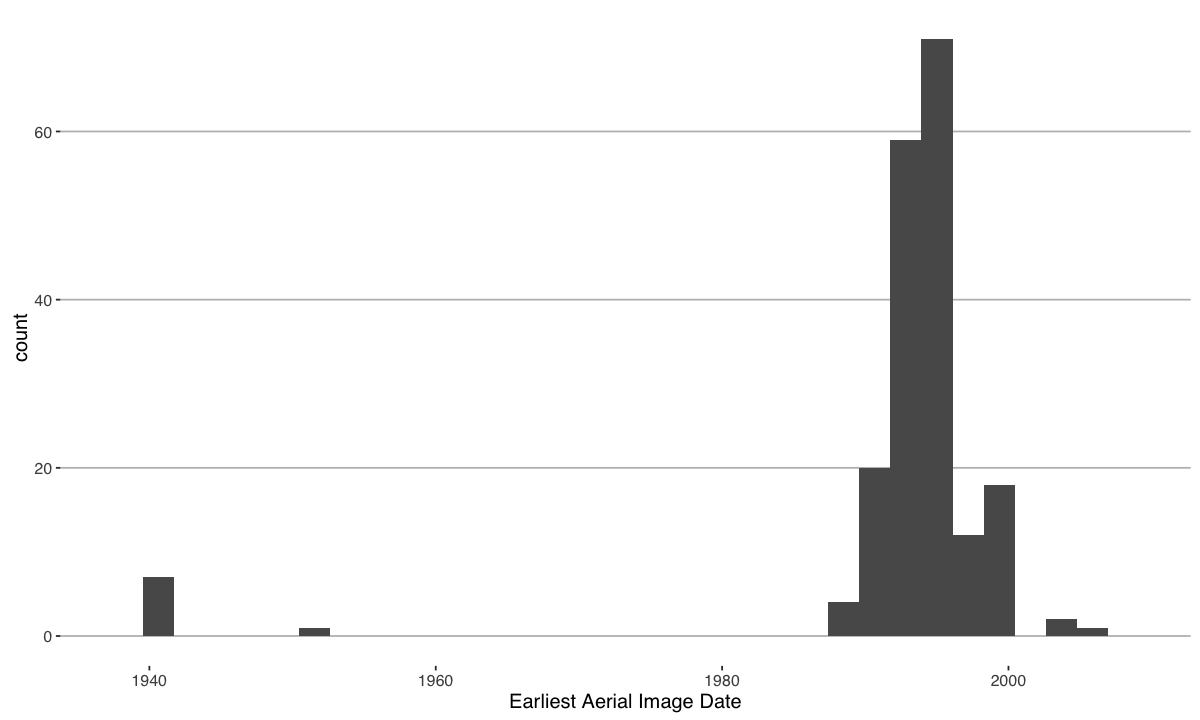

In [23]:
ggplot(combo_dat, aes(earliest_date)) +
    geom_histogram() +
    labs(x = "Earliest Aerial Image Date") +
    theme_hc()

----

### On-track: What are observability rates?

In [24]:
get_observabilities <- function(dat, formal_in) {
    type_mean <- tapply(dat$action_found,
                        INDEX = dat$work_type,
                        FUN = mean, na.rm = TRUE)
    type_median <- tapply(dat$action_found,
                        INDEX = dat$work_type,
                        FUN = median, na.rm = TRUE)
    if (formal_in == "formal") {
        type_count <- tapply(dat$N_formal,
                             INDEX = dat$work_type,
                             FUN = mean, na.rm = TRUE)
    } else {
        type_count <- tapply(dat$N_consultations,
                             INDEX = dat$work_type,
                             FUN = mean, na.rm = TRUE)
    }
    expect_to_see_all <- type_mean * type_count

    # And these are the results at the highest level:
    tot_num_formal <- sum(type_count, na.rm = TRUE)
    exp_num_see <- sum(expect_to_see_all, na.rm = TRUE)
    cat(paste("Observability:\n\t", exp_num_see / tot_num_formal, "\n"))
    cat(paste("# consultations in set:\n\t", tot_num_formal, "\n"))
    cat(paste("# consultations we expect to see effects:\n\t", exp_num_see, "\n"))
}


In [25]:
get_observabilities(form_dat, "formal")

Observability:
	 0.391797110174594 
# consultations in set:
	 1661 
# consultations we expect to see effects:
	 650.775 


In [26]:
get_observabilities(inform_dat, "informal")

Observability:
	 0.351479012345679 
# consultations in set:
	 20250 
# consultations we expect to see effects:
	 7117.45 


35-39% observability isn't great...

I think we need to see how the number of consultations per work category compares to the observability

In [27]:
make_scatter_df <- function(dat, cons_dat, formal_in) {
    type_mean <- tapply(dat$action_found,
                        INDEX = dat$work_type,
                        FUN = mean, na.rm = TRUE)
    type_median <- tapply(dat$action_found,
                        INDEX = dat$work_type,
                        FUN = median, na.rm = TRUE)
    if (formal_in == "formal") {
        type_count <- tapply(dat$N_formal,
                             INDEX = dat$work_type,
                             FUN = mean, na.rm = TRUE)
    } else {
        type_count <- tapply(dat$N_consultations,
                             INDEX = dat$work_type,
                             FUN = mean, na.rm = TRUE)
    }
    expect_to_see_all <- type_mean * type_count

    tmp_dat <- data.frame(type_count = as.vector(type_count),
                          type_mean = as.vector(type_mean),
                          work = names(type_count))
    work_cat_type <- data.frame(cat = cons_dat$work_category,
                                work = as.character(cons_dat$work_type))
    work_cat_type$uniq <- duplicated(work_cat_type$work)
    work_cat_type <- work_cat_type[work_cat_type$uniq == FALSE, ]
    tmp_dat <- inner_join(tmp_dat, work_cat_type, by = "work")
    return(tmp_dat)
}

In [28]:
form_obs_dat <- make_scatter_df(form_dat, form_cons, "formal")
inform_obs_dat <- make_scatter_df(inform_dat, inform_cons, "informal")

Warning message:
In inner_join_impl(x, y, by$x, by$y): joining factors with different levels, coercing to character vector

In [29]:
plot_observability_vs_available <- function(dat) {
    plt <- ggplot(dat, aes(type_mean, type_count)) +
           geom_jitter(width = 0, height = 0.1, alpha = 0.3, size = 4) +
           geom_label_repel(aes(type_mean, 
                                type_count, 
                                fill = factor(cat),
                                label = str_wrap(work, width = 30)), 
                           size = 2,
                           show.legend = FALSE) +
           labs(x = "Mean success rate",
                y = "# consultations in work type") +
           theme_hc()
    plt
}

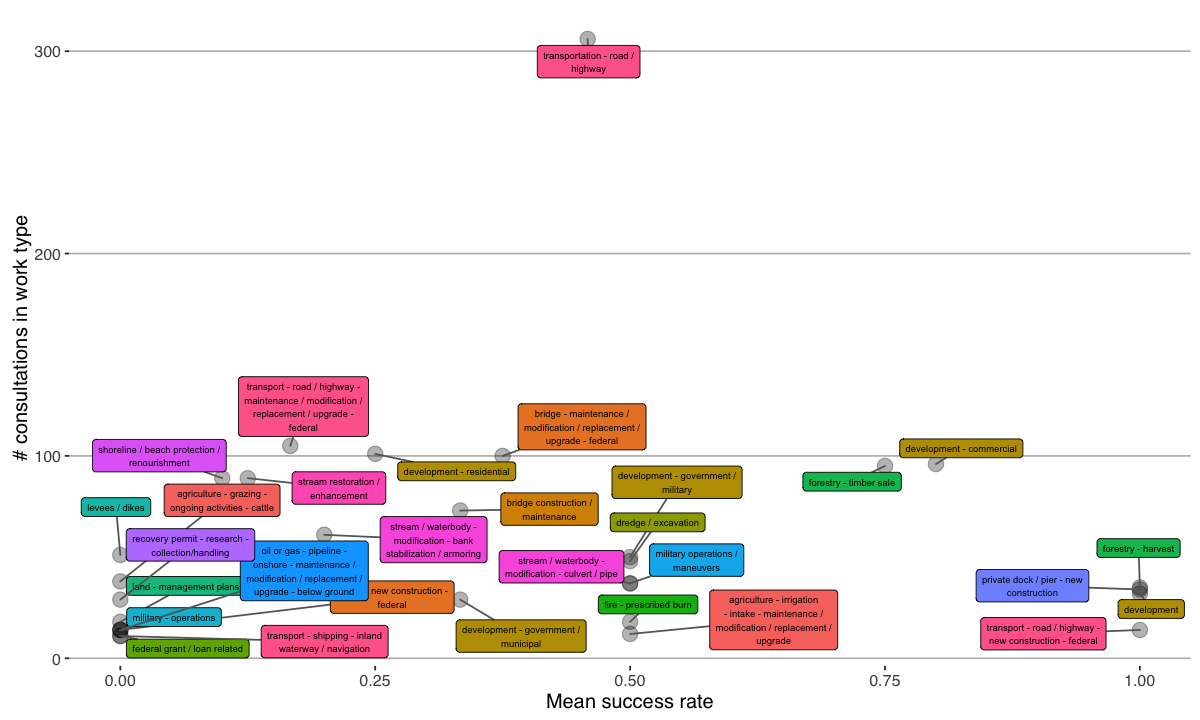

In [30]:
plot_observability_vs_available(form_obs_dat)

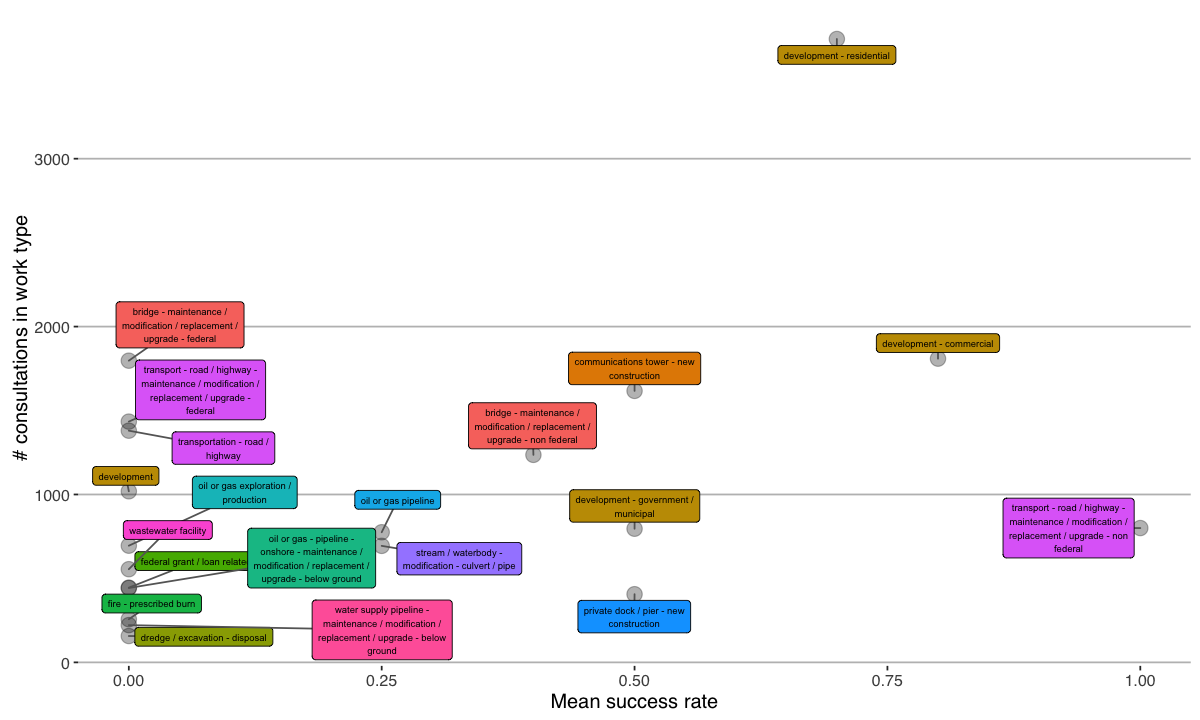

In [31]:
plot_observability_vs_available(inform_obs_dat)

__*I think the conclusion is that there are many consultations for which we will never or only rarely have a chance of seeing anything using aerial imagery.*__

(Note: I wish I could use speech-to-text for these comments!)

----
## Total area

Ultimately we would like to say something about the total area of habitat that has been "given away" under section 7. Even though the sample sizes are relatively small at this point, we can bootstrap sample from the areas that Tiffany has measured and get a distribution of estimated areas affected!

In [32]:
bootstrap_total_area <- function(dat, B = 1000, N) {
    areas <- dat$area[!is.na(dat$area)]
    samp_reps <- rep(NA, B)
    for (i in 1:1000) {
        samp_reps[i] <- sum(sample(areas, replace = TRUE, size = N))
    }
    samp_df <- data.frame(samp_reps)

    plt <- ggplot(samp_df, aes(samp_reps)) +
               geom_histogram() + 
               labs(x = "Sum of sampled areas (acres)",
                    y = "Frequency") +
               theme_hc()
    print(plt)

    print(mean(samp_reps))
    print(quantile(probs = c(0.025, 0.975), samp_reps))
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 121161.5
    2.5%    97.5% 
113319.4 129089.0 


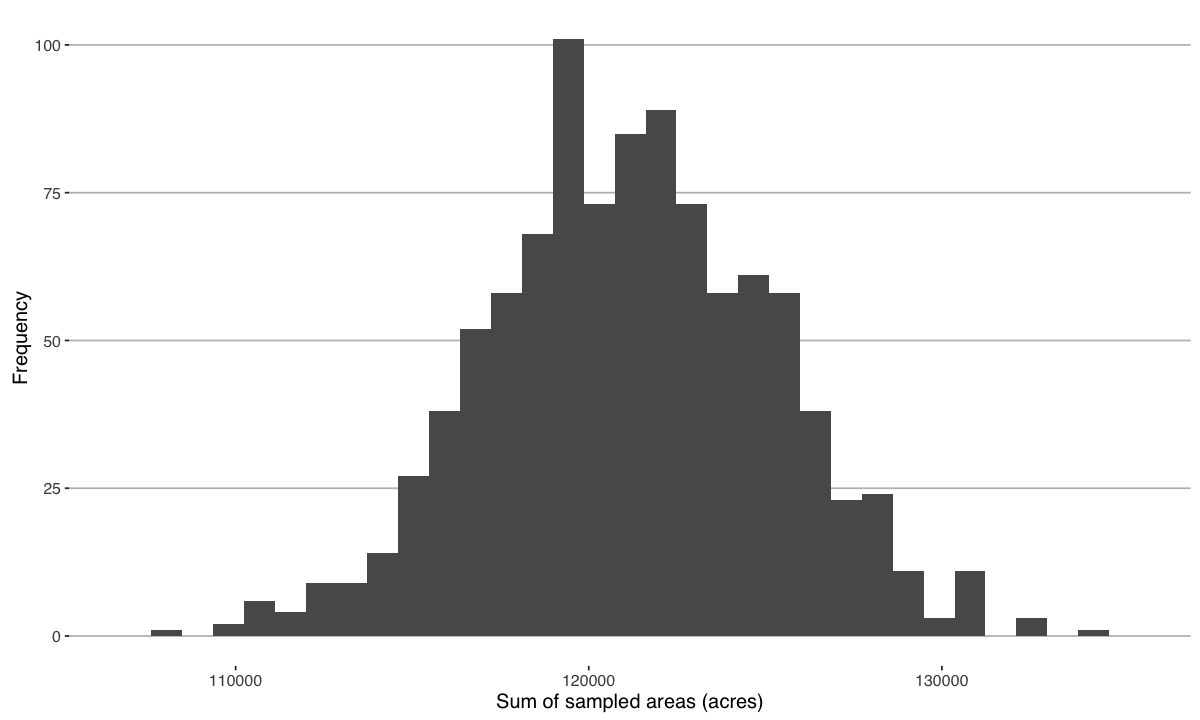

In [33]:
bootstrap_total_area(form_dat, B=1000, N=6829)

So about 120,000 acres for formal consultations...

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 939859.5
    2.5%    97.5% 
928606.2 951812.8 


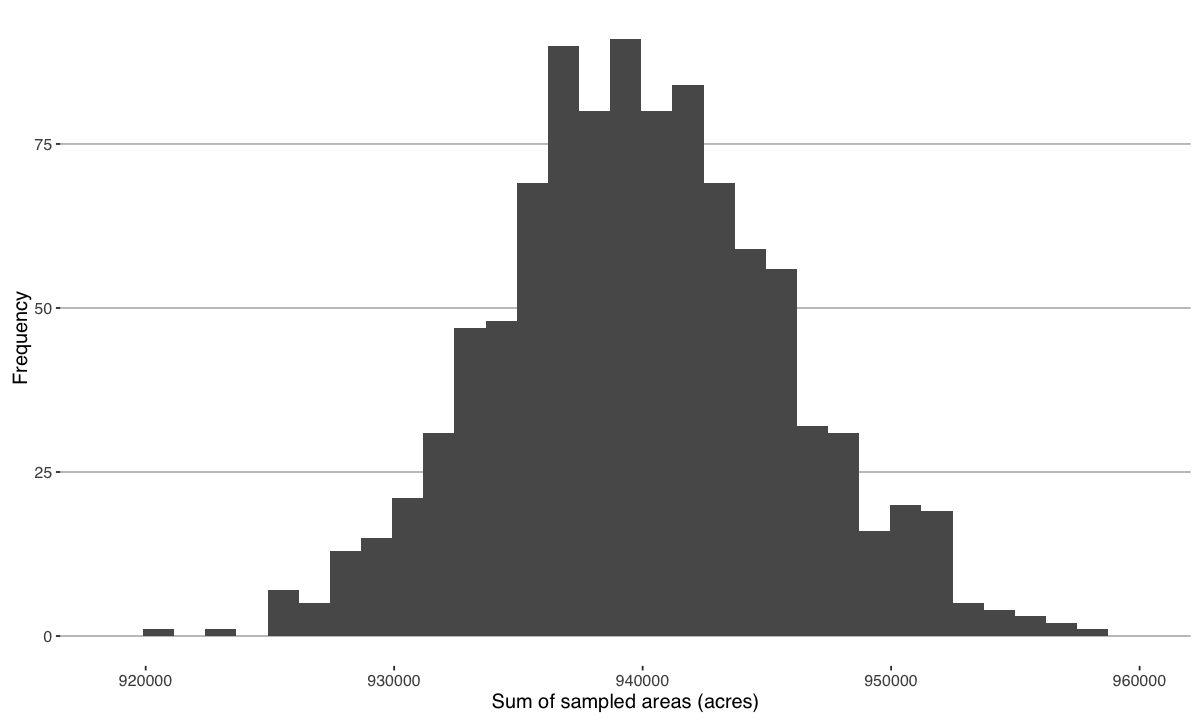

In [34]:
bootstrap_total_area(inform_dat, B=1000, N=81461)

...and about 940,000 acres for informal consultations (!).

----
## Discussion

This is only a preliminary analysis, but the results suggest a few interesting items.

1. There are likely a large number of actions evaluated under section 7 for which aerial imagery isn't going to work very well. A few work categories in particular might be warranted, but we aren't going to be able to monitor compliance of even a majority of actions.
2. The preliminary estimates of the total area of habitat lost under section 7 suggests that the situation isn't good. Over 1,000,000 acres since 2008!
3. But this really begs the question, _How much habitat was lost from 2008-2015 across the entire US?_
  * Detractors of the ESA claims that it "kills the economy". If it turns out that consultation - either informal or formal - accounts for a small percentage of the total habitat lost (a measure of economic output) then their claims are _clearly_ bogus.
  
There will be much more, later.